In [20]:
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
import pyro

Define prior on $\theta$

In [21]:
sigma_theta =torch.eye(1)
mu_theta =torch.zeros(1)
prior_distribution = torch.distributions.MultivariateNormal(mu_theta, sigma_theta) 
prior_log_prob = lambda samples: prior_distribution.log_prob(samples)

Generate $D_\theta$ according to some prior distribution

In [44]:
n_D = 0
D_theta =torch.linspace(-4,4, n_D).unsqueeze(-1)

Generate $D_x$ according to some unknown linear $f(D_\theta)$

In [45]:
sigma_simulateur = 1
f = lambda y: 1*torch.ones(1)@y.T+1
simulateur= lambda theta: f(theta) + torch.randn(theta.shape[0])*sigma_simulateur

D_x = simulateur(D_theta)

Generate $x_0$ according to $f(\theta_0)$ for some unknown $\theta_0$

In [46]:
theta_0 = prior_distribution.sample()
theta_0 = torch.tensor([1.5])
print('theta_0 = ' + str(theta_0.item()))
n_x0= 50
x0 = simulateur(theta_0.unsqueeze(0).repeat(n_x0, 1))

theta_0 = 1.5


Scatter plot of $D$, unknown linear model $f$, histogram of $x_0$

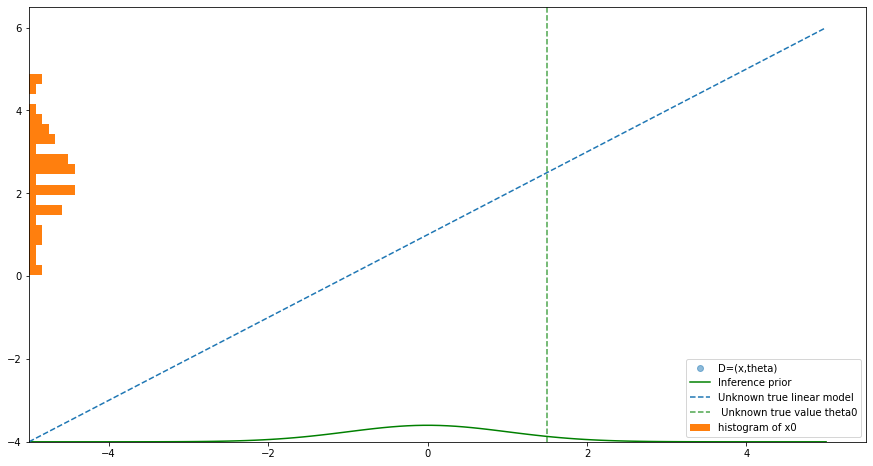

In [47]:
plt.figure(figsize = (15,8))
y_min = -4
plt.scatter(D_theta[:,0].numpy(), D_x.numpy(), alpha =.5, label = 'D=(x,theta)') 
tt = torch.linspace(-5,5,100)
plt.plot(tt, y_min + torch.exp(prior_distribution.log_prob(tt.unsqueeze(-1))), color = 'green', label='Inference prior')
plt.plot(tt.numpy(),f(tt.unsqueeze(-1)).numpy(), linestyle = '--', label = 'Unknown true linear model')
plt.axvline(theta_0.numpy(), color = 'green', alpha = .7, linestyle = '--', label=' Unknown true value theta0')
hist = plt.hist(x0.numpy(), orientation ='horizontal', bins = 20, density = True, bottom = -5, label = 'histogram of x0')
plt.ylim(y_min,)
plt.legend()

In [48]:
def plot_models(models):
    if models.shape[-1]<=2:
        plt.figure()
        tt = torch.linspace(-5,5,100)
        theta_tt = torch.cat([tt.unsqueeze(-1), torch.ones(tt.shape[0]).unsqueeze(-1)], dim = -1)
        x_tt = models@theta_tt.T
        for i in range(models.shape[0]):
            plt.plot(tt, x_tt[i], color = 'black' )
    plt.figure()
    plt.scatter(models[:,-1].numpy(), models[:,-2].numpy())
    plt.show()
    
def plot_2d_function(f, x_min = -10,x_max = 10, y_min = -10, y_max = 10, delta = 200, levels = 2 , alpha = 0.7, new_figure = True):
    if new_figure :
        plt.figure(figsize = (10,10))
        plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    tt_x = torch.linspace(x_min, x_max, delta)
    tt_y = torch.linspace(y_min,y_max, delta)
    mesh = torch.cartesian_prod(tt_x, tt_y)
    with torch.no_grad():
        plt.contourf(tt_x,tt_y,f(mesh).numpy().reshape(delta,delta).T, levels = levels, cmap = matplotlib.cm.get_cmap('viridis'), alpha = alpha)

In [49]:
class bayesian_linear_regression:
    def __init__(self, x0, sigma_simulateur, mu_theta, sigma_theta): 
        self.d = mu_theta.shape[-1]
        
        self.sigma_simulateur = sigma_simulateur
        self.mu_theta = mu_theta
        self.sigma_theta = sigma_theta 
        
        self.mu_phi = torch.zeros(self.d+1)
        self.sigma_phi = torch.eye(self.d+1)

        self.x0=x0
    
    def compute_parameter_likelihood(self, D_theta, D_x):
        assert D_theta.shape[0]>=2,'Must have more than 1 dataset sample'
        assert D_theta.shape[0]==D_x.shape[0], 'Mismatch in number samples'
        temp = torch.cat([D_theta, torch.ones(D_theta.shape[0]).unsqueeze(-1)], dim = -1)
        sigma_d_phi = torch.inverse(temp.T@temp)*self.sigma_simulateur**2
        mu_d_phi = D_x@temp@torch.inverse(temp.T@temp)
        return mu_d_phi,sigma_d_phi 

    def dataset_likelihood(self, beta, D_theta, D_x): 
        assert D_theta>=1,'No dataset'
        temp = torch.cat([D_theta, torch.ones(D_theta.shape[0]).unsqueeze(-1)], dim = -1)
        mean = beta@temp.T
        sigma = (self.sigma_simulateur**2)*torch.eye(self.d).unsqueeze(0).repeat(self.theta_samples.shape[0],1,1)
        return torch.distributions.MultivariateNormal(mean.unsqueeze(-1),sigma).log_prob(D_x.unsqueeze(-1))
        
    def compute_parameter_posterior_parameter(self, D_theta, D_x):
        assert D_theta.shape[0] == D_x.shape[0],'Mismatch in number samples'
        if D_theta.shape[0]>=1:
            temp = torch.cat([D_theta, torch.ones(D_theta.shape[0]).unsqueeze(-1)], dim = -1)
            sigma_phi_d = torch.inverse(temp.T@temp/self.sigma_simulateur**2 + torch.inverse(self.sigma_phi))
            mu_phi_d = sigma_phi_d@(D_x@temp/self.sigma_simulateur**2+ torch.inverse(self.sigma_phi)@self.mu_phi)
        else:
            mu_phi_d, sigma_phi_d = self.mu_phi, self.sigma_phi 
        return mu_phi_d,sigma_phi_d

    def log_joint_prob(self, theta, phi):
        log_prior = torch.distributions.MultivariateNormal(self.mu_theta, self.sigma_theta).log_prob(theta)
        augmented_theta = torch.cat([theta, torch.ones(theta.shape[0],1)], dim = -1)
        temp = torch.bmm(phi.unsqueeze(-2),augmented_theta.unsqueeze(-1)).squeeze(-1)
        temp = temp.repeat(1,self.x0.shape[0])
        cov_matrix = sigma_simulateur * torch.eye(self.x0.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        log_likelihood = torch.distributions.MultivariateNormal(temp, cov_matrix).log_prob(self.x0) if self.x0.shape[0]>=1 else torch.zeros(theta.shape[0])
        log_parameter_posterior = self.parameter_posterior_distribution.log_prob(phi)
        return log_parameter_posterior+log_prior+log_likelihood
    
    def log_likelihood_prob(self,theta, phi):
        augmented_theta = torch.cat([theta, torch.ones(theta.shape[0],1)], dim = -1)
        temp = torch.bmm(phi.unsqueeze(-2),augmented_theta.unsqueeze(-1)).squeeze(-1)
        temp = temp.repeat(1,self.x0.shape[0])
        cov_matrix = sigma_simulateur * torch.eye(self.x0.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        log_likelihood = torch.distributions.MultivariateNormal(temp, cov_matrix).log_prob(self.x0) if self.x0.shape[0]>=1 else torch.zeros(theta.shape[0])
        return log_likelihood
    
    def marginal_log_likelihood_parameters(self, x, theta): 
        mu_phi_d, sigma_phi_d = self.compute_parameter_posterior_parameter()
        gamma = torch.cat([theta, torch.ones(theta.shape[0],1)], dim = -1).unsqueeze(1).repeat(1,x.shape[0],1)
        mean = gamma@mu_phi_d
        cov = gamma@sigma_phi_d.unsqueeze(0).repeat(theta.shape[0],1,1)@torch.transpose(gamma, -2,-1) + self.sigma_simulateur*torch.eye(x.shape[0]).unsqueeze(0).repeat(theta.shape[0],1,1)
        return mean, cov
    
    def marginal_log_likelihood(self, x, theta):
        mean, cov = self.marginal_log_likelihood_parameters(x, theta)
        return torch.distributions.MultivariateNormal(mean, cov).log_prob(x)
    
    def sample_marginal_likelihood(self, num_samples, theta):
        mean, cov = self.marginal_log_likelihood_parameters(torch.zeros(num_samples), theta)
        return torch.distributions.MultivariateNormal(mean, cov).sample()
    
    def compute_posterior_distribution_parameters(self,beta):
        sigma_theta_x0_phi = torch.inverse(torch.inverse(self.sigma_theta) + (self.x0.shape[0]*(beta[0]**2))/self.sigma_simulateur**2)
        mu_theta_x0_phi = sigma_theta_x0_phi@(torch.inverse(self.sigma_theta)@self.mu_theta + beta[0]*torch.sum(self.x0 - beta[1])/self.sigma_simulateur**2)
        return mu_theta_x0_phi, sigma_theta_x0_phi 

Sample joint with Gibbs sampling

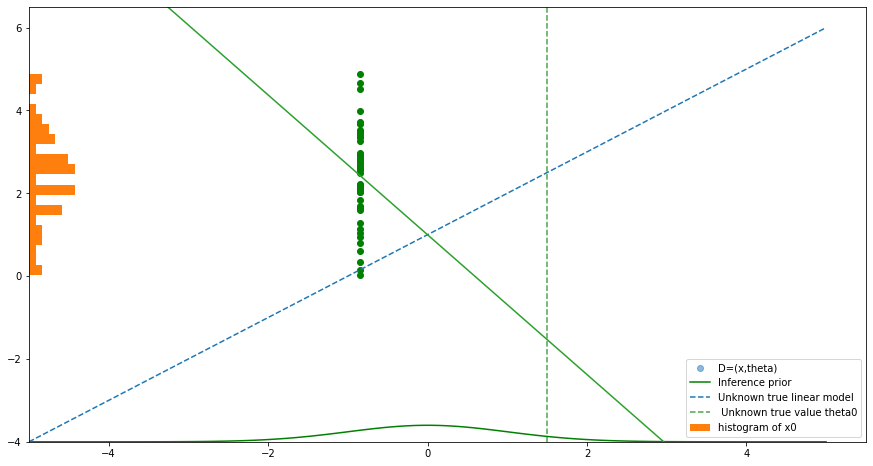

In [50]:
#just to show
import time 
from IPython.display import clear_output

blr = bayesian_linear_regression(x0, sigma_simulateur, mu_theta, sigma_theta)

#initialise with phi|D
mu_phi_D, sigma_phi_D = blr.compute_parameter_posterior_parameter(D_theta, D_x)
current_phi = torch.distributions.MultivariateNormal(mu_phi_D, sigma_phi_D).sample()
#sample theta|phi
mu_theta_x0_phi, sigma_theta_x0_phi = blr.compute_posterior_distribution_parameters(current_phi)
current_theta = torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample()

for t in range(50):
    
    plt.figure(figsize = (15,8))
    y_min = -4
    plt.scatter(D_theta[:,0].numpy(), D_x.numpy(), alpha =.5, label = 'D=(x,theta)') 
    tt = torch.linspace(-5,5,100)
    plt.plot(tt, y_min + torch.exp(prior_distribution.log_prob(tt.unsqueeze(-1))), color = 'green', label='Inference prior')
    plt.plot(tt.numpy(),f(tt.unsqueeze(-1)).numpy(), linestyle = '--', label = 'Unknown true linear model')
    plt.axvline(theta_0.numpy(), color = 'green', alpha = .7, linestyle = '--', label=' Unknown true value theta0')
    hist = plt.hist(x0.numpy(), orientation ='horizontal', bins = 20, density = True, bottom = -5, label = 'histogram of x0')
    plt.ylim(y_min,)
    plt.legend()
    
    current_Theta = current_theta.unsqueeze(0).repeat(x0.shape[0],1)
    plt.scatter(current_Theta[:,0].numpy(), x0.numpy(), label ='Augmenting data', color = 'green')

    
    theta_tt = torch.cat([tt.unsqueeze(-1), torch.ones(tt.shape[0]).unsqueeze(-1)], dim = -1)
    x_tt = current_phi@theta_tt.T
    plt.plot(tt,x_tt)
    plt.show()
    #time.sleep(5)
    clear_output(wait=True)
    
    
    D_theta_plus = torch.cat([D_theta, current_Theta], dim = 0)
    D_x_plus = torch.cat([D_x, x0], dim = 0)
    mu_phi_D_plus, sigma_phi_D_plus = blr.compute_parameter_posterior_parameter(D_theta_plus, D_x_plus)
    current_phi = torch.distributions.MultivariateNormal(mu_phi_D_plus, sigma_phi_D_plus).sample()
    mu_theta_x0_phi, sigma_theta_x0_phi = blr.compute_posterior_distribution_parameters(current_phi)
    current_theta = torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1669.24it/s]


ESS theta  tensor([223.2975])
ESS phi  tensor(366.5701)
ESS phi  tensor(1225.3516)


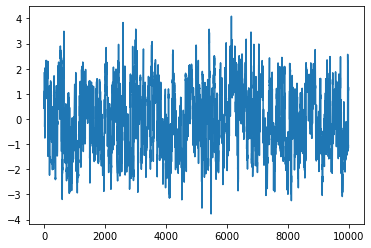

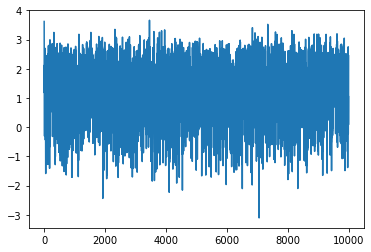

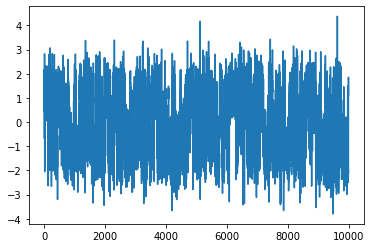

In [51]:
blr = bayesian_linear_regression(x0, sigma_simulateur, mu_theta, sigma_theta)

#initialise with phi|D
mu_phi_D, sigma_phi_D = blr.compute_parameter_posterior_parameter(D_theta, D_x)
current_phi = torch.distributions.MultivariateNormal(mu_phi_D, sigma_phi_D).sample()
#sample theta|phi
mu_theta_x0_phi, sigma_theta_x0_phi = blr.compute_posterior_distribution_parameters(current_phi)
current_theta = torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample()

list_theta_gibbs = [current_theta]
list_phi_gibbs = [current_phi]
for t in tqdm(range(10000)):
    current_Theta = current_theta.unsqueeze(0).repeat(x0.shape[0],1)
    D_theta_plus = torch.cat([D_theta, current_Theta], dim = 0)
    D_x_plus = torch.cat([D_x, x0], dim = 0)
    mu_phi_D_plus, sigma_phi_D_plus = blr.compute_parameter_posterior_parameter(D_theta_plus, D_x_plus)
    current_phi = torch.distributions.MultivariateNormal(mu_phi_D_plus, sigma_phi_D_plus).sample()
    mu_theta_x0_phi, sigma_theta_x0_phi = blr.compute_posterior_distribution_parameters(current_phi)
    current_theta = torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample()
    list_theta_gibbs.append(current_theta)
    list_phi_gibbs.append(current_phi)
print('ESS theta ', pyro.ops.stats.effective_sample_size(torch.stack(list_theta_gibbs).unsqueeze(1),chain_dim = 1, sample_dim =0))
print('ESS phi ', pyro.ops.stats.effective_sample_size(torch.stack(list_phi_gibbs)[:,0].unsqueeze(1), chain_dim = 1, sample_dim = 0))
print('ESS phi ', pyro.ops.stats.effective_sample_size(torch.stack(list_phi_gibbs)[:,1].unsqueeze(1), chain_dim = 1, sample_dim = 0))
plt.plot(torch.stack(list_theta_gibbs)[:,0])
plt.show()
plt.plot(torch.stack(list_phi_gibbs)[:,1])
plt.show()
plt.plot(torch.stack(list_phi_gibbs)[:,0])
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1580.67it/s]


ESS theta  tensor([1654.8694])
ESS phi  tensor(2055.8799)
ESS phi  tensor(1820.8853)


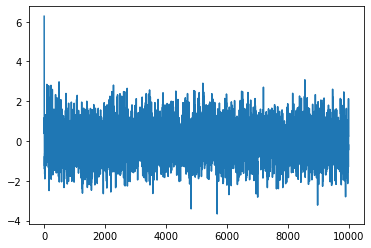

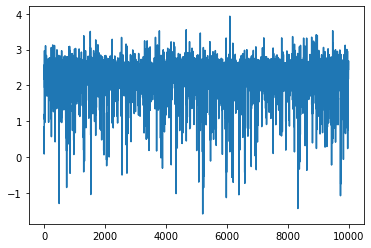

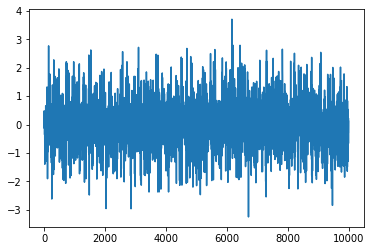

In [52]:
blr = bayesian_linear_regression(x0, sigma_simulateur, mu_theta, sigma_theta)
#initialise with phi|D
mu_phi_D, sigma_phi_D = blr.compute_parameter_posterior_parameter(D_theta, D_x)
current_phi = torch.distributions.MultivariateNormal(mu_phi_D, sigma_phi_D).sample()
#sample theta|phi
mu_theta_x0_phi, sigma_theta_x0_phi = blr.compute_posterior_distribution_parameters(current_phi)
current_Theta = torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample([n_x0])

list_theta_weird_gibbs = [current_Theta[0]]
list_phi_weird_gibbs = [current_phi]
for t in tqdm(range(10000)):
    D_theta_plus = torch.cat([D_theta, current_Theta], dim = 0)
    D_x_plus = torch.cat([D_x, x0], dim = 0)
    mu_phi_D_plus, sigma_phi_D_plus = blr.compute_parameter_posterior_parameter(D_theta_plus, D_x_plus)
    current_phi = torch.distributions.MultivariateNormal(mu_phi_D_plus, sigma_phi_D_plus).sample()
    mu_theta_x0_phi, sigma_theta_x0_phi = blr.compute_posterior_distribution_parameters(current_phi)
    current_Theta = torch.distributions.MultivariateNormal(mu_theta_x0_phi, sigma_theta_x0_phi).sample([n_x0])
    list_theta_weird_gibbs.append(current_Theta[0])
    list_phi_weird_gibbs.append(current_phi)
print('ESS theta ', pyro.ops.stats.effective_sample_size(torch.stack(list_theta_weird_gibbs).unsqueeze(1),chain_dim = 1, sample_dim =0))
print('ESS phi ', pyro.ops.stats.effective_sample_size(torch.stack(list_phi_weird_gibbs)[:,0].unsqueeze(1), chain_dim = 1, sample_dim = 0))
print('ESS phi ', pyro.ops.stats.effective_sample_size(torch.stack(list_phi_weird_gibbs)[:,1].unsqueeze(1), chain_dim = 1, sample_dim = 0))
plt.plot(torch.stack(list_theta_weird_gibbs)[:,0])
plt.show()
plt.plot(torch.stack(list_phi_weird_gibbs)[:,1])
plt.show()
plt.plot(torch.stack(list_phi_weird_gibbs)[:,0])
plt.show()

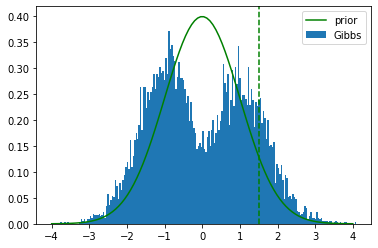

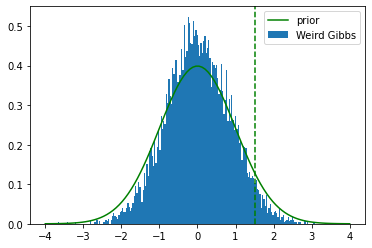

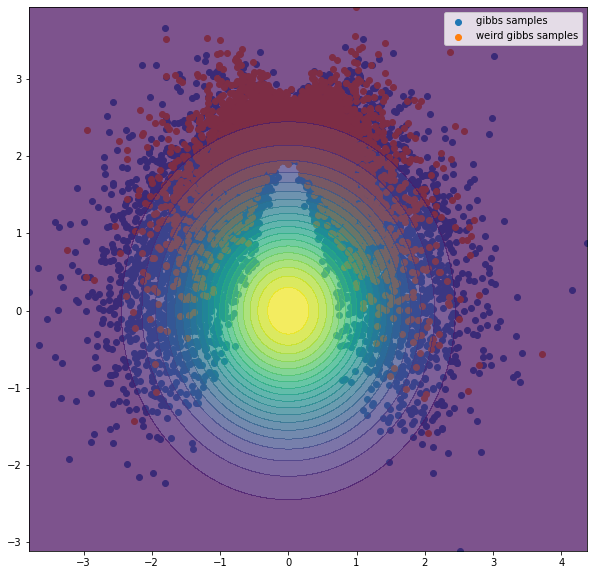

In [53]:
models_phi_gibbs = torch.stack(list_phi_gibbs[1000:], dim=0)
models_phi_weird_gibbs = torch.stack(list_phi_weird_gibbs[1000:], dim=0)
total_phi = torch.stack(list_phi_gibbs[1000:] + list_phi_weird_gibbs[1000:])
tt = torch.linspace(-4,4,100)
plt.plot(tt, torch.exp(prior_log_prob(tt.unsqueeze(-1))), color = 'green', label = 'prior')
hist=plt.hist(torch.cat(list_theta_gibbs[1000:], dim = 0).numpy(), bins= 200, label = 'Gibbs', density = True)
plt.axvline(theta_0.numpy(), color = 'green', linestyle = '--')
plt.legend()
plt.show()
plt.plot(tt, torch.exp(prior_log_prob(tt.unsqueeze(-1))), color = 'green', label = 'prior')
hist=plt.hist(torch.cat(list_theta_weird_gibbs[1000:], dim = 0).numpy(), bins= 200, label ='Weird Gibbs', density = True)
plt.axvline(theta_0.numpy(), color = 'green', linestyle = '--')
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
plt.scatter(models_phi_gibbs[1000:,0].numpy(), models_phi_gibbs[1000:,1].numpy(), label = 'gibbs samples')
plt.scatter(models_phi_weird_gibbs[:,0].numpy(), models_phi_weird_gibbs[:,1].numpy(), label = 'weird gibbs samples')
mu_phi_D, sigma_phi_D = blr.compute_parameter_posterior_parameter(D_theta, D_x)
parameter_posterior_distribution = torch.distributions.MultivariateNormal(mu_phi_D, sigma_phi_D)
plot_2d_function(lambda samples:torch.exp(parameter_posterior_distribution.log_prob(samples)),x_min = torch.min(total_phi[:,0]), x_max = torch.max(total_phi[:,0]),y_min = torch.min(total_phi[:,1]), y_max = torch.max(total_phi[:,1]),levels = 25, new_figure = False)
plt.legend()
plt.show()

Compare these Gibbs with IMH

In [54]:
blr = bayesian_linear_regression(x0, sigma_simulateur, mu_theta, sigma_theta)
mu_phi_D, sigma_phi_D = blr.compute_parameter_posterior_parameter(D_theta, D_x)
def IMH(number_chains, number_steps):
    sample_phi = torch.distributions.MultivariateNormal(mu_phi_D, sigma_phi_D).sample([number_chains])
    sample_theta = prior_distribution.sample([number_chains])
    for t in tqdm(range(number_steps)):
        proposed_phi = torch.distributions.MultivariateNormal(mu_phi_D, sigma_phi_D).sample([number_chains])
        proposed_theta = prior_distribution.sample([number_chains])
        acceptance_log_prob = blr.log_likelihood_prob(proposed_theta, proposed_phi) - blr.log_likelihood_prob(sample_theta, sample_phi)
        mask = ((torch.rand(number_chains) < torch.exp(acceptance_log_prob)) * 1.).unsqueeze(-1)
        sample_phi = (mask) * proposed_phi + (1 - (mask)) * sample_phi
        sample_theta = (mask) * proposed_theta + (1-(mask))*sample_theta
    return sample_theta, sample_phi

In [55]:
sample_theta, sample_phi = IMH(10000,50)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.00it/s]


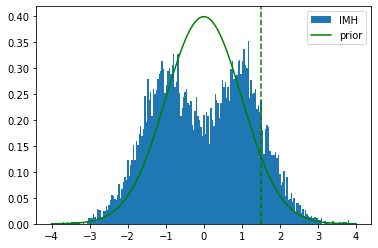

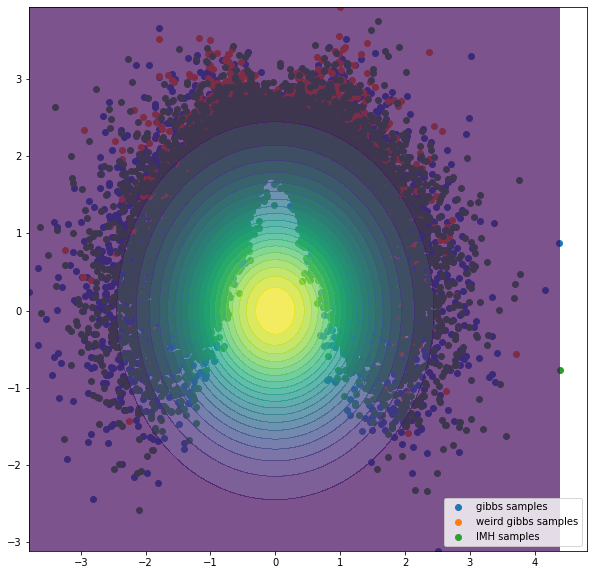

In [62]:
hist=plt.hist(sample_theta.numpy(), bins= 200,density = True,label ='IMH')
tt = torch.linspace(-4,4,100)
plt.plot(tt, torch.exp(prior_log_prob(tt.unsqueeze(-1))), color = 'green', label = 'prior')
plt.axvline(theta_0.numpy(), color = 'green', linestyle = '--')
plt.legend()
plt.show()
fig = plt.figure(figsize = (10,10))
plt.scatter(models_phi_gibbs[:,0].numpy(), models_phi_gibbs[:,1].numpy(), label = 'gibbs samples')
plt.scatter(models_phi_weird_gibbs[:,0].numpy(), models_phi_weird_gibbs[:,1].numpy(), label = 'weird gibbs samples')
plt.scatter(sample_phi[:,0].numpy(), sample_phi[:,1].numpy(), label = 'IMH samples')
mu_phi_D, sigma_phi_D = blr.compute_parameter_posterior_parameter(D_theta, D_x)
parameter_posterior_distribution = torch.distributions.MultivariateNormal(mu_phi_D, sigma_phi_D)
plot_2d_function(lambda samples:torch.exp(parameter_posterior_distribution.log_prob(samples)),x_min = torch.min(total_phi[:,0]), x_max = torch.max(total_phi[:,0]),y_min = torch.min(total_phi[:,1]), y_max = torch.max(total_phi[:,1]),levels = 25, new_figure = False)
plt.legend()
plt.show()

In [63]:
import numpy
def make_histogram_2d(sample, delta = 25,new_figure = True, show = False, cmap='viridis'):
    if new_figure:
        fig = plt.figure(figsize = (10,10))
    hist, x_edges, y_edges = numpy.histogram2d(sample[:,0].numpy(), sample[:,1].numpy(), bins = (delta, delta))
    plt.contourf(x_edges[:-1], y_edges[:-1],hist.T, alpha = 1, levels = 100, cmap = cmap)
    if show:
        plt.show()

<Figure size 720x720 with 0 Axes>

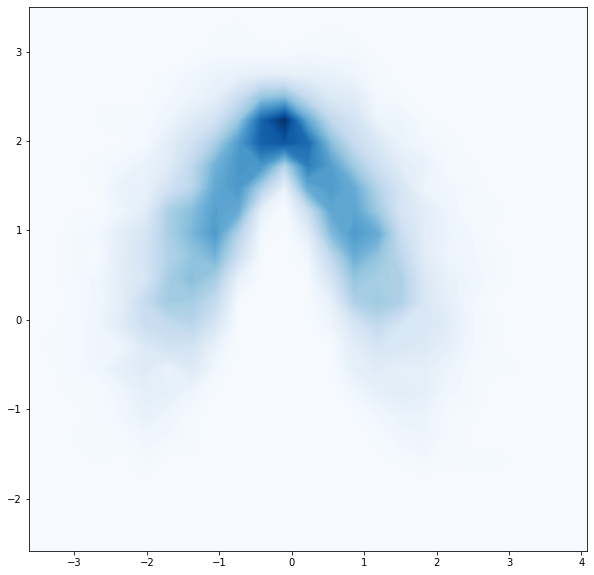

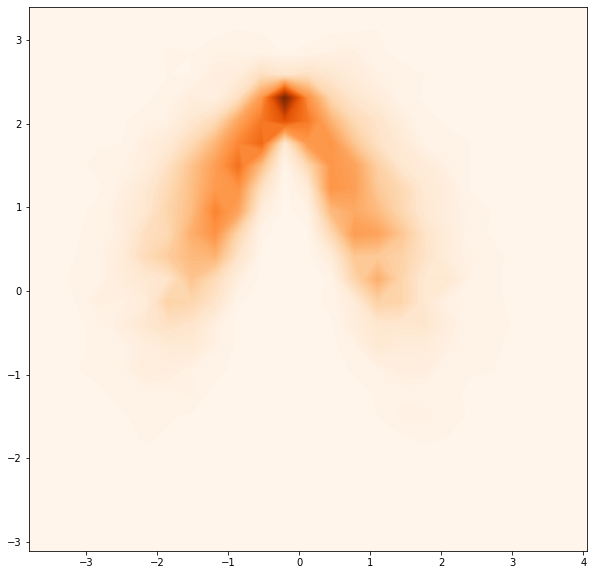

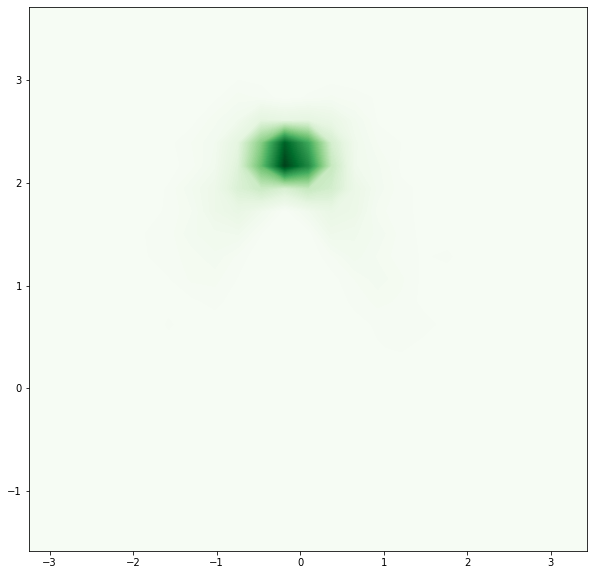

In [64]:
fig = plt.figure(figsize = (10,10))
make_histogram_2d(sample_phi, cmap = 'Blues' )
make_histogram_2d(models_phi_gibbs,cmap = 'Oranges')
make_histogram_2d(models_phi_weird_gibbs,cmap = 'Greens')
plt.show()

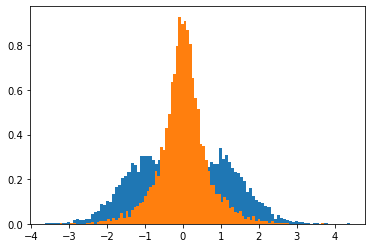

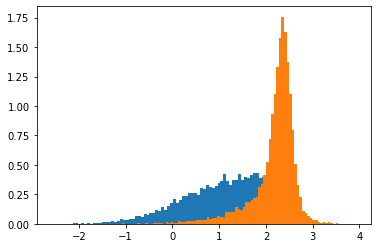

In [67]:
plt.hist(sample_phi[1000:,0].numpy(), bins = 100,density = True)
plt.hist(models_phi_weird_gibbs[1000:,0].numpy(),bins= 100, density = True)
plt.show()
plt.hist(sample_phi[1000:,1].numpy(), bins = 100,density = True)
plt.hist(models_phi_weird_gibbs[1000:,1].numpy(),bins= 100, density = True)
plt.show()

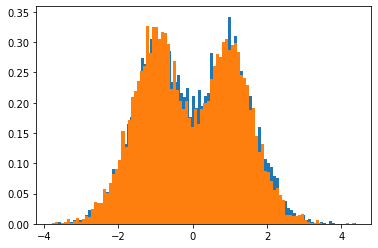

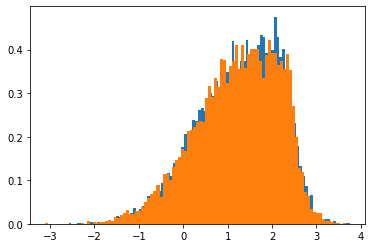

In [68]:
plt.hist(sample_phi[1000:,0].numpy(), bins = 100,density = True)
plt.hist(models_phi_gibbs[1000:,0].numpy(),bins= 100, density = True)
plt.show()
plt.hist(sample_phi[1000:,1].numpy(), bins = 100,density = True)
plt.hist(models_phi_gibbs[1000:,1].numpy(),bins= 100, density = True)
plt.show()

In [69]:
print('ESS theta ', pyro.ops.stats.effective_sample_size(sample_theta.unsqueeze(1),chain_dim = 1, sample_dim =0))

ESS theta  tensor([9918.3896])
